In [77]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path, PurePosixPath
import textwrap


In [78]:
## File location

CSV_NAME1 = "https://raw.githubusercontent.com/Staiana/AgriPV/main/AgriPV_V2.csv"


In [79]:
##Create the new columns necessary

def load_pvgis_multiseason(path) -> pd.DataFrame:
    """Parse a 3‑row PVGIS extract (season, geography, variable)."""

    wide = pd.read_csv(path, header=[0,1,2], index_col=0, encoding="latin1")
    seasons = []; geos = []; vars_ = []
    last_s = last_g = None
    for s,g,v in wide.columns:
        if s and not str(s).startswith("Unnamed"):
            last_s = str(s).strip()
        if g and not str(g).startswith("Unnamed"):
            last_g = str(g).strip()
        seasons.append(last_s); geos.append(last_g); vars_.append(str(v).strip())
    wide.columns = pd.MultiIndex.from_arrays([seasons, geos, vars_],
                                             names=["season","geometry","variable"])
    long = (wide
            .stack(level=["season","geometry"])
            .reset_index()
            .rename(columns={"level_0":"hour"}))
    long = long.rename(columns={
        "GlobHor":"GlobHor",
        "DiffHor":"DiffHor",
        "T_Amb"  :"T_Amb",
        "T_GH": "T_GH"
    })
    long = long[["season","geometry","hour","GlobHor","DiffHor","T_Amb", "T_GH"]]
    long["co2_conc"] = 420.0  # assumption
    return long

data = load_pvgis_multiseason(CSV_NAME1)

# numeric coercion & drop NaNs
for c in ["GlobHor","DiffHor","T_Amb"]:
    data[c] = pd.to_numeric(data[c], errors="coerce")
data = data.dropna(subset=["GlobHor","T_Amb"])



# ---------------------------------------------------------------------------
# Conversions and Assumptions For Tomato!  ----------------------------------------------
# ---------------------------------------------------------------------------

PAR_FRACTION = 0.45          # ≈45 % of broadband solar radiation lies in 400-700 nm
J_TO_PHOTON = 4.6            # W m-2 (PAR) → μmol m-2 s-1

# --- 1. Convert broadband irradiance (W m-2) → PPFD (μmol m-2 s-1) ---------
#     Broadband  W × 0.45  →  PAR-W;  PAR-W ×4.6 → photons
#     Coefficient 0.45 × 4.6 ≃ 2.1  (used worldwide for quick PAR estimates)
data["PPFD_Glob"] = data["GlobHor"] * 2.1      #  ⭐ CHANGED (was ×4.6)
data["PPFD_Diff"] = data["DiffHor"] * 2.1      #  ⭐ CHANGED (was ×4.6)

# --- 2. Keep a photon-based “PAR” column for the FvCB model -----------------
#     (variable name kept for backward-compatibility with downstream code)
data["PAR_Glob"]  = data["PPFD_Glob"]           #  ⭐ CHANGED (was ×4.6)

# --- 3. Apply greenhouse shade factor (75 %) directly to photon flux --------
data["PPFD_Glob_Shade"] = data["PPFD_Glob"] * 0.75      #  ⭐ CHANGED (was GlobHor ×0.75)
data["PPFD_Diff_Shade"] = data["PPFD_Diff"] * 0.75      #  ⭐ CHANGED
data["PAR_Glob_Shade"]  = data["PPFD_Glob"]  * 0.75     #  ⭐ CHANGED (was PAR_Glob ×0.75)

# ---------------------------------------------------------------------------
# 2. BIOCHEMICAL MODEL (FvCB)  ----------------------------------------------
# ---------------------------------------------------------------------------

R = 8.314
Ha = dict(Kc=79.43e3, Ko=36.38e3, Gamma=37.83e3, Vcmax=65.33e3, Jmax=43.90e3)
p25= dict(Kc=404.9, Ko=278.4e3, Gamma=42.75, Vcmax=60, Jmax=120, Rd=1.0)
alpha, theta = 0.24, 0.7
O2 = 210000.0

def arr(x25, Ha_J, T):
    return x25 * np.exp(Ha_J * (T - 298.15)/(R*T*298.15))

def temp_resp(tC):
    T = tC + 273.15
    return dict(
        Kc    = arr(p25["Kc"], Ha["Kc"], T),
        Ko    = arr(p25["Ko"], Ha["Ko"], T),
        Gamma = arr(p25["Gamma"], Ha["Gamma"], T),
        Vcmax = arr(p25["Vcmax"],Ha["Vcmax"],T),
        Jmax  = arr(p25["Jmax"], Ha["Jmax"], T),
        Rd    = p25["Rd"] * (2**((tC-25)/10))
    )

def j_rate(I, Jmax):
    return (alpha*I + Jmax - np.sqrt((alpha*I + Jmax)**2 - 4*theta*alpha*I*Jmax)) / (2*theta)

def fvbc_row(row):
    p = temp_resp(row["T_Amb"])
    Ci = 0.7*row["co2_conc"]
    Wc = p["Vcmax"] * (Ci - p["Gamma"]) / (Ci + p["Kc"]*(1+O2/p["Ko"]))
    J  = j_rate(row["PAR_Glob"], p["Jmax"])
    Wj = J * (Ci - p["Gamma"]) / (4.5*Ci + 10.5*p["Gamma"])
    return min(Wc, Wj) - p["Rd"]


def fvbc_with_inputs(ppfd, temp_C, ca_ppm=420.0):
    p  = temp_resp(temp_C)
    Ci = 0.7 * ca_ppm
    Wc = p["Vcmax"] * (Ci - p["Gamma"]) / (Ci + p["Kc"] * (1 + O2 / p["Ko"]))
    J  = j_rate(ppfd, p["Jmax"])
    Wj = J * (Ci - p["Gamma"]) / (4.5 * Ci + 10.5 * p["Gamma"])
    return min(Wc, Wj) - p["Rd"]

data["A_n_Gh"] = data.apply(
    lambda r: fvbc_with_inputs(r["PAR_Glob_Shade"], r["T_GH"], r["co2_conc"]),
    axis=1
)

data["A_n"] = data.apply(fvbc_row, axis=1)
data = data.drop_duplicates(subset=["season", "geometry", "hour"])




<ipython-input-79-3590759327>:18: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=["season","geometry"])


In [80]:
display(data.head(40))

variable,season,geometry,hour,GlobHor,DiffHor,T_Amb,T_GH,co2_conc,PPFD_Glob,PPFD_Diff,PAR_Glob,PPFD_Glob_Shade,PPFD_Diff_Shade,PAR_Glob_Shade,A_n_Gh,A_n
0,Equinoxe Mars,Aillas,06:00,0.0,0.0,8.0,8.0,420.0,0.00,0.00,0.00,0.0000,0.0000,0.0000,-0.307786,-0.307786
1,Equinoxe Mars,Guadeloupe,06:00,10.4,10.4,21.8,NaN,420.0,21.84,21.84,21.84,16.3800,16.3800,16.3800,NaN,-0.020717
2,Equinoxe Septembre,Aillas,06:00,0.2,0.2,11.7,11.7,420.0,0.42,0.42,0.42,0.3150,0.3150,0.3150,-0.384398,-0.379943
3,Equinoxe Septembre,Guadeloupe,06:00,92.6,43.1,23.1,NaN,420.0,194.46,90.51,194.46,145.8450,67.8825,145.8450,NaN,4.976096
4,Solstice Eté,Aillas,06:00,103.0,59.3,16.4,16.4,420.0,216.30,124.53,216.30,162.2250,93.3975,162.2250,4.663475,5.812755
5,Solstice Eté,Guadeloupe,06:00,97.8,74.1,25.6,NaN,420.0,205.38,155.61,205.38,154.0350,116.7075,154.0350,NaN,4.922295
6,Solstice hiver,Aillas,06:00,0.0,0.0,4.1,4.1,420.0,0.00,0.00,0.00,0.0000,0.0000,0.0000,-0.234881,-0.234881
7,Solstice hiver,Guadeloupe,06:00,2.5,2.4,21.5,NaN,420.0,5.25,5.04,5.25,3.9375,3.7800,3.9375,NaN,-0.593572
8,Equinoxe Mars,Aillas,07:00,14.8,14.8,8.4,8.4,420.0,31.08,31.08,31.08,23.3100,23.3100,23.3100,0.668481,0.976513
9,Equinoxe Mars,Guadeloupe,07:00,213.8,128.8,23.2,NaN,420.0,448.98,270.48,448.98,336.7350,202.8600,336.7350,NaN,9.368512


In [81]:
color_map = {
    ("Aillas","GlobHor"): "darkorange",
    ("Aillas","DiffHor"): "royalblue",
    ("Guadeloupe","GlobHor"): "crimson",
    ("Guadeloupe","DiffHor"): "purple"
}
psn_colors = {"Aillas":"red", "Guadeloupe":"limegreen"}

season_map = {
    "Equinoxe Mars"      : "Spring Equinox",
    "Equinoxe Septembre" : "Autumn Equinox",
    "Solstice Eté"       : "Summer Solstice",
    "Solstice hiver"     : "Winter Solstice"
}


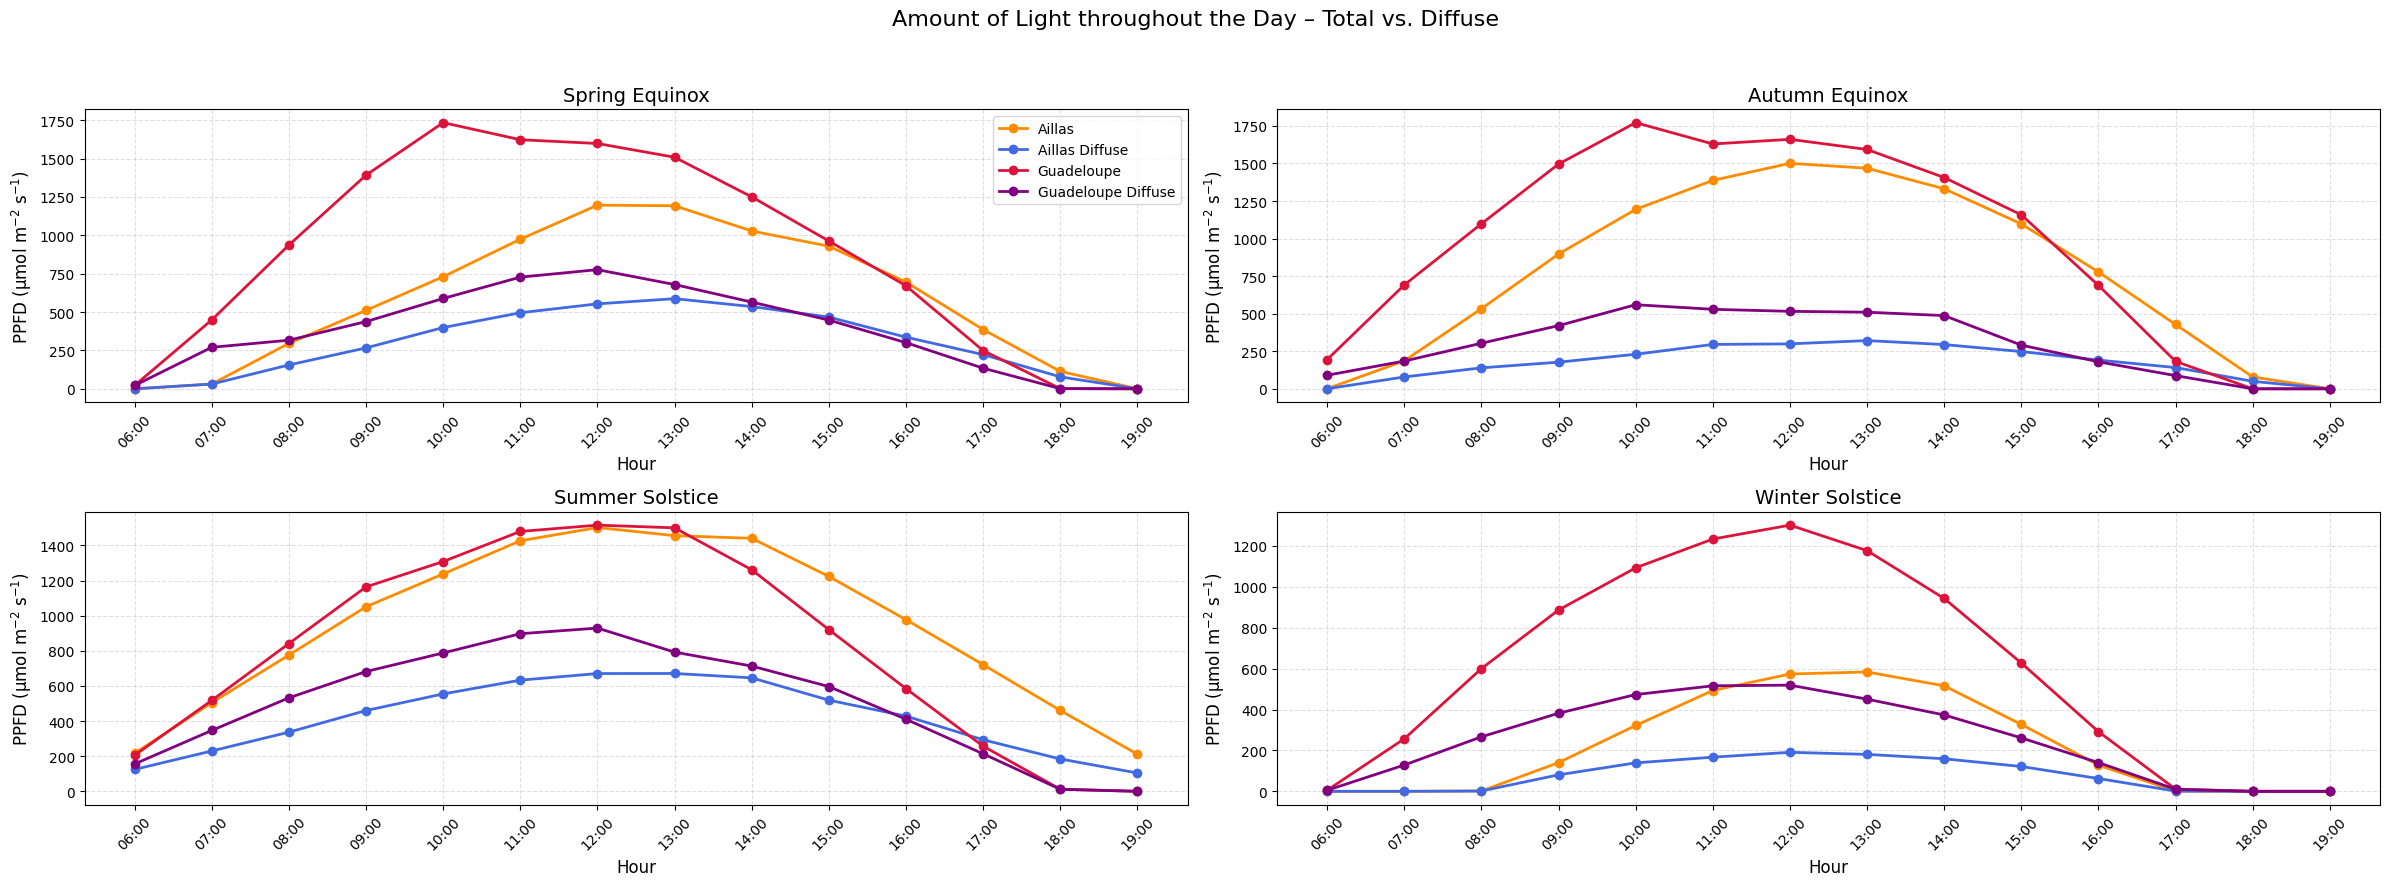

In [82]:





# ---------------------------------------------------------------------------
# 3. VISUALISATION  ----------------------------------------------------------
# ---------------------------------------------------------------------------
# Seasons order as encountered
seasons = data["season"].drop_duplicates().tolist()
rows = (len(seasons)+1)//2
cols = 2 if len(seasons)>1 else 1


# ---- PPFD FIGURE -----
fig_ppfd, axes = plt.subplots(rows, cols, figsize=(12*cols, 4.5*rows), squeeze=False)

for i, season in enumerate(seasons):
    ax  = axes[i//cols][i%cols]
    sdf = data[data["season"] == season]

    # use English name if available

    for geo, gdf in sdf.groupby("geometry"):
        # iterate through both radiation components
        for comp, col_ppfd in [("GlobHor", "PPFD_Glob"),
                               ("DiffHor", "PPFD_Diff")]:

            label = f"{geo}" if comp == "GlobHor" else f"{geo} Diffuse"

            # >>> plotting must be inside this loop
            ax.plot(gdf["hour"], gdf[col_ppfd],
                    marker="o", lw=2,
                    color=color_map[(geo, comp)],
                    label=label)
            # <<<

    ax.set_title(season_map.get(season, season), fontsize=14)
    ax.set_xlabel("Hour", fontsize=12)
    ax.set_ylabel("PPFD (µmol m$^{-2}$ s$^{-1}$)", fontsize=12)
    ax.set_xticks(gdf["hour"].unique())
    ax.set_xticklabels(gdf["hour"].unique(), rotation=45)
    ax.grid(ls="--", alpha=0.4)

    if i == 0:
        ax.legend(loc="upper right", frameon=True)

fig_ppfd.suptitle("Amount of Light throughout the Day – Total vs. Diffuse", fontsize=16)
fig_ppfd.tight_layout(rect=[0, 0, 1, 0.95])



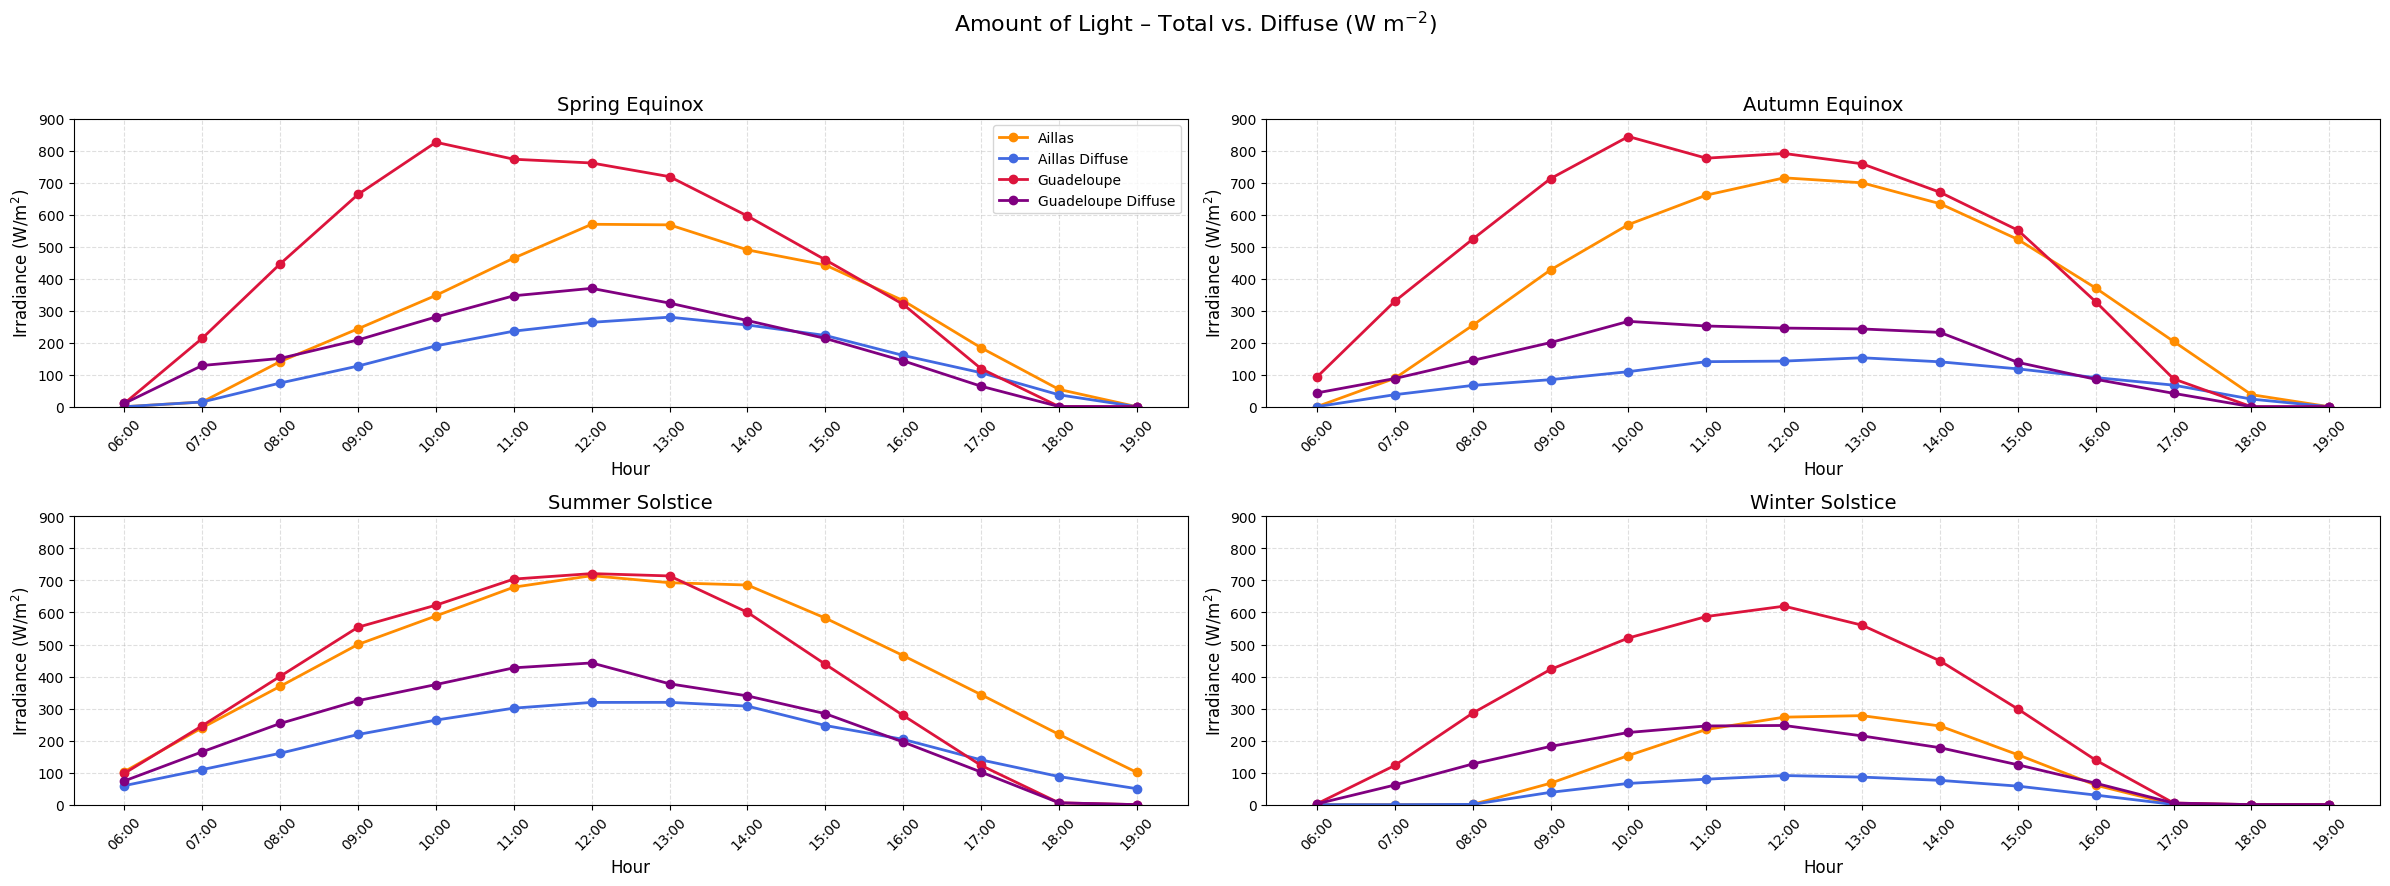

In [83]:
# ---------------------------------------------------------------------------
# 3-bis. VISUALISATION (Watts m⁻²)  -----------------------------------------
# ---------------------------------------------------------------------------
# Seasons order
seasons = data["season"].drop_duplicates().tolist()
rows    = (len(seasons) + 1) // 2
cols    = 2 if len(seasons) > 1 else 1

fig_w, axes = plt.subplots(rows, cols,
                           figsize=(12 * cols, 4.5 * rows),
                           squeeze=False)

for i, season in enumerate(seasons):
    ax  = axes[i // cols][i % cols]
    sdf = data[data["season"] == season]

    for geo, gdf in sdf.groupby("geometry"):
        for comp, col_w in [("GlobHor", "GlobHor"),
                            ("DiffHor", "DiffHor")]:

            label = f"{geo}" if comp == "GlobHor" else f"{geo} Diffuse"

            ax.plot(gdf["hour"], gdf[col_w],
                    marker="o", lw=2,
                    color=color_map[(geo, comp)],
                    label=label)

    ax.set_title(season_map.get(season, season), fontsize=14)
    ax.set_xlabel("Hour", fontsize=12)
    ax.set_ylabel("Irradiance (W/m$^{2}$)", fontsize=12)
    ax.set_xticks(gdf["hour"].unique())
    ax.set_xticklabels(gdf["hour"].unique(), rotation=45)
    ax.grid(ls="--", alpha=0.4)
    ax.set_ylim(0, 900)          # lettuce saturates <~8–9


    if i == 0:
        ax.legend(loc="upper right", frameon=True)

fig_w.suptitle("Amount of Light – Total vs. Diffuse (W m$^{-2}$)", fontsize=16)
fig_w.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


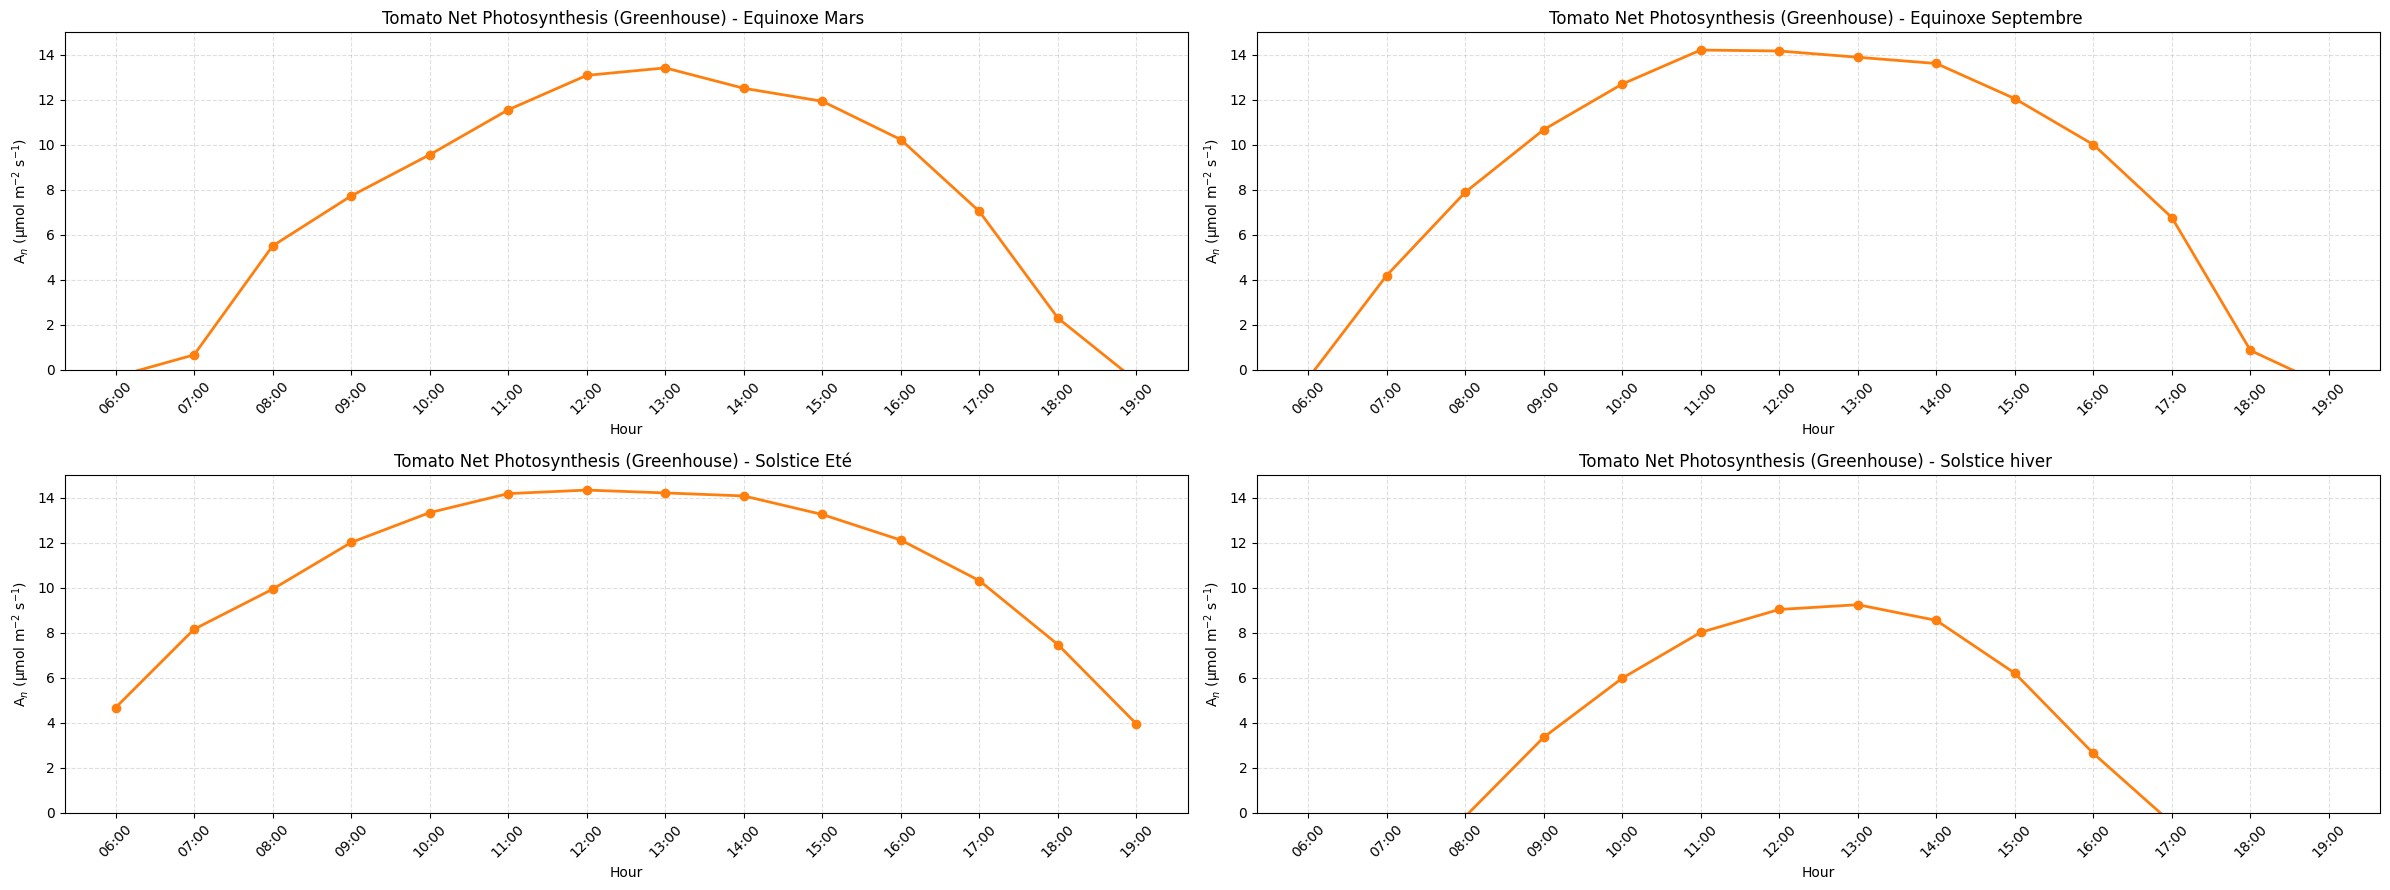

In [84]:
seasons = data["season"].drop_duplicates()
rows, cols = (len(seasons) + 1) // 2, 2 if len(seasons) > 1 else 1
fig, axes = plt.subplots(rows, cols, figsize=(12*cols, 4.5*rows), squeeze=False)

for i, s in enumerate(seasons):
    ax  = axes[i//cols][i%cols]
    sdf = data[data["season"] == s]
    for geo, gdf in sdf.groupby("geometry"):
        ax.plot(gdf["hour"], gdf["A_n_Gh"],
                marker="o", lw=2, color="#ff7f0e",
                label=geo if i == 0 else "_nolegend_")
    ax.set(title=f"Tomato Net Photosynthesis (Greenhouse) - {s} ",
           xlabel="Hour", ylabel="A$_n$ (µmol m$^{-2}$ s$^{-1}$)")
    ax.set_xticks(gdf["hour"].unique())
    ax.set_xticklabels(gdf["hour"].unique(), rotation=45)
    ax.grid(ls="--", alpha=.4)
    ax.set_ylim(0, 15)          # lettuce saturates <~8–9


plt.tight_layout()
plt.show()


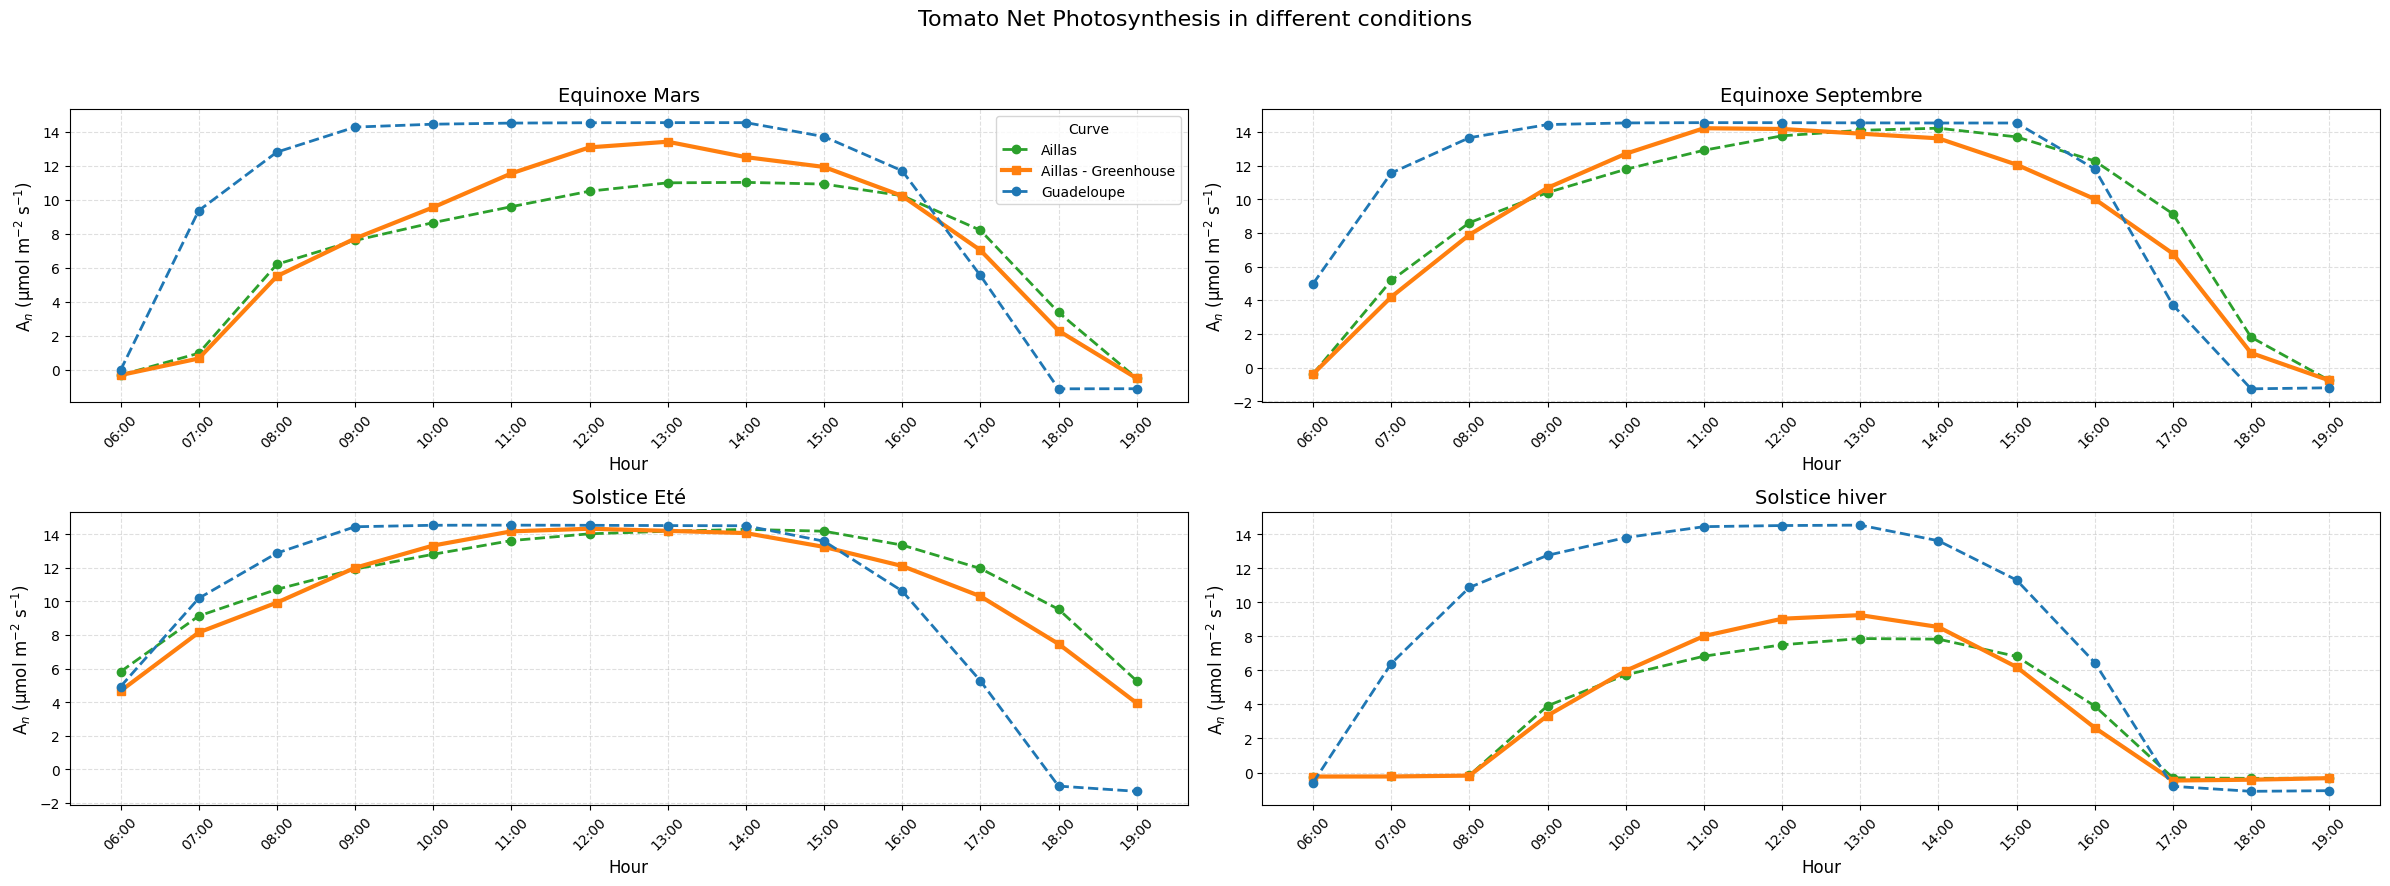

In [85]:
# ────────────────────────────────────────────────────────────
# 1.  Update color palette for maximum contrast
# ────────────────────────────────────────────────────────────
psn_colors = {
    "Aillas": "#2ca02c",      # medium green
    "Guadeloupe": "#1f77b4"   # classic blue
}
gh_color = "#ff7f0e"          # bright orange for greenhouse

# ────────────────────────────────────────────────────────────
# 2.  Replace your PSN plotting block with this adjusted code
# ────────────────────────────────────────────────────────────
fig_psn, axes2 = plt.subplots(rows, cols,
                              figsize=(12*cols, 4.5*rows),
                              squeeze=False)

for i, season in enumerate(seasons):
    ax  = axes2[i//cols][i%cols]
    sdf = data[data["season"] == season]
    unique_hours = sdf["hour"].unique()

    for geo, gdf in sdf.groupby("geometry"):
        # 1) Leaf photosynthesis
        ax.plot(
            gdf["hour"], gdf["A_n"],
            marker='o', ls='--', lw=2,
            color=psn_colors[geo],
            label=geo if i == 0 else "_nolegend_"
        )
        # 2) Greenhouse simulation (T_GH) only for Aillas
        if geo == "Aillas":
            ax.plot(
                gdf["hour"], gdf["A_n_Gh"],
                marker='s',  lw=3,
                color=gh_color,
                label=("Aillas - Greenhouse" if i == 0 else "_nolegend_")
            )

    # Panel styling
    ax.set_title(season, fontsize=14)
    ax.set_xlabel("Hour", fontsize=12)
    ax.set_ylabel("A$_n$ (µmol m$^{-2}$ s$^{-1}$)", fontsize=12)
    ax.set_xticks(unique_hours)
    ax.set_xticklabels(unique_hours, rotation=45)
    ax.grid(ls='--', alpha=0.4)

    if i == 0:
        ax.legend(title="Curve", frameon=True)

fig_psn.suptitle("Tomato Net Photosynthesis in different conditions", fontsize=16)
fig_psn.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [86]:
def lettuce_an(ppfd, alpha=0.03, a_max=8.5):
    """Empirical net photosynthesis of shade-grown lettuce."""
    return (alpha * ppfd) / (1 + (alpha * ppfd / a_max))

# Median shade level: 25 % shade → transmit 75 % of incident PPFD
data["PPFD_Lettuce"] = data["PPFD_Glob"] * 0.75
data["A_n_Lettuce"]  = lettuce_an(data["PPFD_Lettuce"])

# ────────────────────────────────────────────────────────────────
# 1.  Plot Solstice Été – Aillas   (PPFD vs. Lettuce Aₙ)
# ────────────────────────────────────────────────────────────────
import pandas as pd, matplotlib.pyplot as plt

mask = (data["season"] == "Solstice Eté") & (data["geometry"] == "Aillas")
sdf  = data.loc[mask].copy()

# convert hour string → numeric for plotting
sdf["hour_num"] = (pd.to_datetime(sdf["hour"], format="%H:%M").dt.hour +
                   pd.to_datetime(sdf["hour"], format="%H:%M").dt.minute/60)


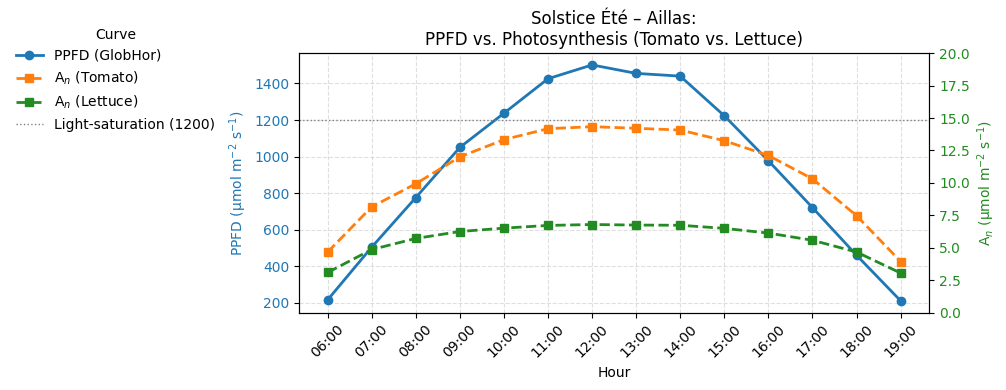

In [87]:


# ───────────────────────────────────────────────────────────────
# 1.  Filter Solstice Été · Aillas
# ───────────────────────────────────────────────────────────────
sdf = data[(data["season"] == "Solstice Eté") &
           (data["geometry"] == "Aillas")].copy()

# convert hour for safe numeric plotting
sdf["hour_num"] = (pd.to_datetime(sdf["hour"], format="%H:%M").dt.hour +
                   pd.to_datetime(sdf["hour"], format="%H:%M").dt.minute/60)

# ───────────────────────────────────────────────────────────────
# 2.  Dual-axis plot: PPFD + two photosynthesis curves
# ───────────────────────────────────────────────────────────────
fig, ax1 = plt.subplots(figsize=(8, 4))

# LEFT y-axis — PPFD (C₃ leaf input)
ax1.plot(sdf["hour_num"], sdf["PPFD_Glob"],
         marker="o", lw=2, color="tab:blue", label="PPFD (GlobHor)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("PPFD (µmol m$^{-2}$ s$^{-1}$)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_xticks(sdf["hour_num"])
ax1.set_xticklabels(sdf["hour"], rotation=45)

# RIGHT y-axis — Net photosynthesis
ax2 = ax1.twinx()
# (a) C₃ greenhouse curve
ax2.plot(sdf["hour_num"], sdf["A_n_Gh"],
         marker="s", ls="--", lw=2, color="tab:orange",
         label="A$_n$ (Tomato)")

ax2.plot(sdf["hour_num"], sdf["A_n_Lettuce"],
         's--', lw=2, color="forestgreen",
         label="A$_n$ (Lettuce)")
ax2.set_ylabel("A$_n$ (µmol m$^{-2}$ s$^{-1}$)", color="forestgreen")
ax2.tick_params(axis="y", labelcolor="forestgreen")
ax2.set_ylim(0, 20)          # lettuce saturates <~8–9

ax1.grid(ls="--", alpha=0.4)

# Combined legend
lines = ax1.get_lines() + ax2.get_lines()
labels = [l.get_label() for l in lines]

plt.title("Solstice Été – Aillas:\nPPFD vs. Photosynthesis (Tomato vs. Lettuce)")


# … your existing plot code …

# 1) Saturation reference line – give it an explicit label you want
sat_val = 1200
ax1.axhline(sat_val, color="grey", ls=":", lw=1,
            label="Light-saturation (Tomato)")

# 2) Collect handles manually and order them
handles = [
    ax1.lines[0],            # PPFD blue
    ax2.lines[0],            # Tomato orange
    ax2.lines[1],            # Lettuce green
    ax1.lines[-1]            # grey saturation line
]
labels = [
    "PPFD (GlobHor)",
    "A$_n$ (Tomato)",
    "A$_n$ (Lettuce)",
    "Light-saturation (1200)"
]

fig.legend(handles, labels,
           loc="upper right", bbox_to_anchor=(0.02, 0.95),
           title="Curve", frameon=False)

plt.tight_layout()
plt.show()



#CSV Daily

In [88]:

base = "https://raw.githubusercontent.com/Staiana/AgriPV/main/{}"
read_kwargs = dict(encoding="latin1")          # handles non-UTF-8 characters

# --- 1. Load the three CSV files -------------------------------------------
df_aillas     = pd.read_csv(base.format("Aillas_Daily.csv"),
                            parse_dates=["date"], **read_kwargs)

df_guadeloupe = pd.read_csv(base.format("Guadeloupe_Daily.csv"),
                            parse_dates=["date"], **read_kwargs)

# --- 2. Combine daily records (outer join → no data lost) -------------------
df_daily = (df_aillas
            .merge(df_guadeloupe, on="date", how="outer",
                   suffixes=("_Aillas", "_Guadeloupe"))
            .sort_values("date", ignore_index=True))



<ipython-input-88-2700656059>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_aillas     = pd.read_csv(base.format("Aillas_Daily.csv"),
<ipython-input-88-2700656059>:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_guadeloupe = pd.read_csv(base.format("Guadeloupe_Daily.csv"),


In [89]:
# --- 3. Add greenhouse temperature (T_Gh) -----------------------------------
# • Use the hourly ΔT matrix → monthly-mean ΔT
# • Add the proper monthly ΔT to each row’s ambient T_Amb_Aillas

# 3-a.  Monthly mean ΔT (°C) from the hour × month table
delta_tbl   = pd.read_csv(base.format("Ghouse_DeltaT.csv"),
                          index_col=0, encoding="latin1")
delta_month = delta_tbl.mean()                    # Series indexed by French month names

In [90]:
delta_tbl["Janvier"] = delta_tbl["Janvier"].fillna(0.0)
delta_tbl["Février"] = delta_tbl["Février"].fillna(0.0)
delta_tbl["Mars"] = delta_tbl["Mars"].fillna(0.0)
delta_tbl["Avril"] = delta_tbl["Avril"].fillna(0.0)
delta_tbl["Mai"] = delta_tbl["Mai"].fillna(0.0)
delta_tbl["Juin"] = delta_tbl["Juin"].fillna(0.0)
delta_tbl["Juillet"] = delta_tbl["Juillet"].fillna(0.0)
delta_tbl["Aout"] = delta_tbl["Aout"].fillna(0.0)
delta_tbl["Sep"] = delta_tbl["Sep"].fillna(0.0)
delta_tbl["Oct"] = delta_tbl["Nv"].fillna(0.0)
delta_tbl["Dec"] = delta_tbl["Dec"].fillna(0.0)

In [91]:
# --- Manually add missing early/late hours with 0.0 values ------------------
missing_hours = [f"{h:02d}:00" for h in list(range(0, 6)) + list(range(20, 24))]
for hr in missing_hours:
    if hr not in delta_tbl.index:
        delta_tbl.loc[hr] = [0.0] * delta_tbl.shape[1]

# --- Clean residual NaNs (if any) and sort by hour --------------------------
delta_tbl = delta_tbl.fillna(0.0).sort_index()


In [92]:
# --- Add greenhouse ΔT from full hourly delta_tbl ---------------------------
# Assumes delta_tbl has rows "00:00"–"23:00" and French month columns

# 1. Build lookup map: month + hour → ΔT
delta_map = delta_tbl.stack().rename_axis(["hour_str", "month_fr"]).to_dict()
df_daily = df_daily.iloc[1:]  # delete the first row
df_daily["date"] = pd.to_datetime(df_daily["date"], errors="coerce")  # ensure datetime with time preserved
# 2. Get each row’s (month, hour) keys
df_daily["hour_str"] = df_daily["date"].dt.strftime("%H:00")
df_daily["month_fr"] = df_daily["date"].dt.month.map({
    1:"Janvier", 2:"Février", 3:"Mars", 4:"Avril", 5:"Mai", 6:"Juin",
    7:"Juillet", 8:"Aout", 9:"Sep", 10:"Oct", 11:"Nv", 12:"Dec"
})

# 3. Lookup ΔT, add to T_Amb_Aillas
df_daily["T_Amb_Aillas"] = pd.to_numeric(df_daily["T_Amb_Aillas"], errors="coerce")

df_daily["T_Gh_Aillas"] = df_daily.apply(
    lambda r: r["T_Amb_Aillas"] + delta_map.get((r["hour_str"], r["month_fr"]), 0.0),
    axis=1
)

# 4. Clean up temporary columns
df_daily.drop(columns=["hour_str", "month_fr"], inplace=True)


<ipython-input-92-647954218>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily["date"] = pd.to_datetime(df_daily["date"], errors="coerce")  # ensure datetime with time preserved
<ipython-input-92-647954218>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily["hour_str"] = df_daily["date"].dt.strftime("%H:00")
<ipython-input-92-647954218>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [93]:
df_daily.head(10)

,date,GlobHor_Aillas,DiffHor_Aillas,T_Amb_Aillas,GlobHor_Guadeloupe,DiffHor_Guadeloupe,T_Amb_Guadeloupe,T_Gh_Aillas
1,1990-01-01 00:00:00,0,0,-2.3602,0,0,24.61,-2.3602
2,1990-01-01 01:00:00,0,0,-2.5797,0,0,25.97,-2.5797
3,1990-01-01 02:00:00,0,0,-2.8601,0,0,25.71,-2.8601
4,1990-01-01 03:00:00,0,0,-2.9997,0,0,25.66,-2.9997
5,1990-01-01 04:00:00,0,0,-3.1399,0,0,25.58,-3.1399
6,1990-01-01 05:00:00,0,0,-3.2903,0,0,25.55,-3.2903
7,1990-01-01 06:00:00,0,0,-3.3899,0.9008,0.8961,25.51,-3.3899
8,1990-01-01 07:00:00,0,0,-3.4902,43.093,42.504,25.93,-3.4902
9,1990-01-01 08:00:00,0.3919,0.3919,-3.4800,103.7,102.3,26.4,-3.4800
10,1990-01-01 09:00:00,46.7,43.801,-2.4001,160.2,158.1,26.86,0.5999


In [94]:
# 1. Numeric coercion & drop rows missing key inputs
for c in ["GlobHor_Aillas","DiffHor_Aillas","T_Amb_Aillas",
          "GlobHor_Guadeloupe","DiffHor_Guadeloupe","T_Amb_Guadeloupe"]:
    df_daily[c] = pd.to_numeric(df_daily[c], errors="coerce")
df_daily = df_daily.dropna(subset=["GlobHor_Aillas","T_Amb_Aillas",
                                   "GlobHor_Guadeloupe","T_Amb_Guadeloupe"])

# 2. Conversions & shade assumptions
# — Aillas ambient
df_daily["PPFD_Glob_Aillas"]      = df_daily["GlobHor_Aillas"] * 2.1
df_daily["PPFD_Diff_Aillas"]      = df_daily["DiffHor_Aillas"] * 2.1
df_daily["PAR_Glob_Aillas"]       = df_daily["GlobHor_Aillas"] * 4.6
df_daily["PPFD_Glob_Shade_Aillas"] = df_daily["GlobHor_Aillas"] * 0.75
df_daily["PPFD_Diff_Shade_Aillas"] = df_daily["DiffHor_Aillas"] * 0.75
df_daily["PAR_Glob_Shade_Aillas"]  = df_daily["PAR_Glob_Aillas"] * 0.75

# — Guadeloupe ambient
df_daily["PPFD_Glob_Guadeloupe"]      = df_daily["GlobHor_Guadeloupe"] * 2.1
df_daily["PPFD_Diff_Guadeloupe"]      = df_daily["DiffHor_Guadeloupe"] * 2.1
df_daily["PAR_Glob_Guadeloupe"]       = df_daily["GlobHor_Guadeloupe"] * 4.6
df_daily["PPFD_Glob_Shade_Guadeloupe"] = df_daily["GlobHor_Guadeloupe"] * 0.75
df_daily["PPFD_Diff_Shade_Guadeloupe"] = df_daily["DiffHor_Guadeloupe"] * 0.75
df_daily["PAR_Glob_Shade_Guadeloupe"]  = df_daily["PAR_Glob_Guadeloupe"] * 0.75

# 3. Compute net photosynthesis (FvCB model)
df_daily["A_n_Aillas"]      = df_daily.apply(lambda r: fvbc_with_inputs(r["PAR_Glob_Aillas"],      r["T_Amb_Aillas"]),      axis=1)
df_daily["A_n_Gh_Aillas"]   = df_daily.apply(lambda r: fvbc_with_inputs(r["PAR_Glob_Shade_Aillas"], r["T_Gh_Aillas"]),       axis=1)
df_daily["A_n_Guadeloupe"]  = df_daily.apply(lambda r: fvbc_with_inputs(r["PAR_Glob_Guadeloupe"],   r["T_Amb_Guadeloupe"]), axis=1)

# (optional) drop intermediate PPFD/PAR columns if no longer needed


<ipython-input-94-1280054777>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily["PPFD_Glob_Aillas"]      = df_daily["GlobHor_Aillas"] * 2.1
<ipython-input-94-1280054777>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily["PPFD_Diff_Aillas"]      = df_daily["DiffHor_Aillas"] * 2.1
<ipython-input-94-1280054777>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

# Monthly Photosynthesis

In [95]:
df_daily.describe()

,date,GlobHor_Aillas,DiffHor_Aillas,T_Amb_Aillas,GlobHor_Guadeloupe,DiffHor_Guadeloupe,T_Amb_Guadeloupe,T_Gh_Aillas,PPFD_Glob_Aillas,PPFD_Diff_Aillas,...,PAR_Glob_Shade_Aillas,PPFD_Glob_Guadeloupe,PPFD_Diff_Guadeloupe,PAR_Glob_Guadeloupe,PPFD_Glob_Shade_Guadeloupe,PPFD_Diff_Shade_Guadeloupe,PAR_Glob_Shade_Guadeloupe,A_n_Aillas,A_n_Gh_Aillas,A_n_Guadeloupe
count,3456,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.00000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,1990-06-22 11:30:00,150.239904,72.314201,13.451195,211.963498,101.141013,26.036086,14.473113,315.503799,151.859822,...,518.327670,445.123345,212.396127,975.03209,158.972623,75.855760,731.274067,4.296602,4.283868,5.662275
min,1990-01-01 00:00:00,0.000000,0.000000,-5.280000,0.000000,0.000000,15.240000,-5.280000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.401527,-1.401527,-1.479388
25%,1990-03-27 05:45:00,0.000000,0.000000,7.979800,0.000000,0.000000,23.900000,8.359800,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.351876,-0.356815,-0.965936
50%,1990-06-21 23:30:00,1.894100,1.894100,13.165000,2.194800,2.096500,26.060000,13.840000,3.977610,3.977610,...,6.534645,4.609080,4.402650,10.09608,1.646100,1.572375,7.572060,-0.038227,-0.120148,-0.589024
75%,1990-09-17 11:15:00,245.852500,120.925000,18.402500,396.650000,186.325000,28.330000,19.740000,516.290250,253.942500,...,848.191125,832.965000,391.282500,1824.59000,297.487500,139.743750,1368.442500,9.326554,9.415739,14.342303
max,1990-12-12 23:00:00,1070.100000,466.900000,36.300000,1073.400000,554.000000,32.840000,47.560000,2247.210000,980.490000,...,3691.845000,2254.140000,1163.400000,4937.64000,805.050000,415.500000,3703.230000,14.548070,14.548070,14.548070
std,NaN,227.367464,104.935851,7.327189,290.755983,136.480468,3.047626,8.228776,477.471675,220.365288,...,784.417752,610.587564,286.608983,1337.47752,218.066987,102.360351,1003.108140,5.454613,5.533701,7.225143


##Monthly


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import acos, tan, radians, degrees   # for day-length


In [97]:
def day_length_hours(date, lat_deg):
    """
    Approximate length of the daylight period (hours) for a given calendar date
    and latitude using the Spencer (1971) declination formula.
    """
    n = date.timetuple().tm_yday                                # day of year (1-365/366)

    # solar declination (degrees)
    decl = 23.44 * np.sin(np.deg2rad(360 * (284 + n) / 365))

    # hour angle at sunrise/sunset (radians); clip keeps acos in domain
    lat_r  = radians(lat_deg)
    decl_r = radians(decl)
    cos_ω  = np.clip(-tan(lat_r) * tan(decl_r), -1.0, 1.0)
    ω      = acos(cos_ω)                                        # radians

    return 24 * ω / np.pi                                       # hours


In [98]:
LAT_AILLAS      = 44.5    # °N  (approximate)
LAT_GUADELOUPE  = 16.3    # °N, Caribbean

def energy_to_ppfd(row, energy_col, lat_deg):
    """
    From daily GHI energy (kWh m⁻² day⁻¹) ➜ average daylight PPFD (µmol m⁻² s⁻¹)
    1) kWh → Joule, 2) ÷ daylight seconds → W m⁻², 3) W → µmol s⁻¹ m⁻² (× 4.6)
    """
    # --- 1. energy (kWh m⁻²) → J m⁻²
    E_J = row[energy_col] * 3.6e6

    # --- 2. daylight seconds
    dl_hours = day_length_hours(row.name, lat_deg)
    dl_sec   = dl_hours * 3600

    # --- 3. average irradiance (W m-²) and PPFD (µmol m-² s-¹)
    P_Wm2      = E_J / dl_sec
    ppfd_μmol  = P_Wm2 * 4.6
    return ppfd_μmol


In [99]:
# ────────────────────────────────────────────────────────────────────────────
# 1.  Make sure the *index itself* is a clean, fully-parsed DateTimeIndex
# ────────────────────────────────────────────────────────────────────────────
df_daily = df_daily.set_index("date")
df_daily = df_daily[~df_daily.index.isna()]                 # drop rows where index is NaT

# ────────────────────────────────────────────────────────────────────────────
# 2.  Now every row.name used inside energy_to_ppfd is a proper datetime,
#     so the helper (which calls .timetuple()) will work without error.
# ────────────────────────────────────────────────────────────────────────────
df_daily["PPFD_Aillas"] = df_daily.apply(
    energy_to_ppfd, axis=1, energy_col="GlobHor_Aillas", lat_deg=LAT_AILLAS)

df_daily["PPFD_Guadeloupe"] = df_daily.apply(
    energy_to_ppfd, axis=1, energy_col="GlobHor_Guadeloupe", lat_deg=LAT_GUADELOUPE)

# PV-greenhouse shading factor (75 % of full PAR)
df_daily["PPFD_Aillas_Gh"] = df_daily["PPFD_Aillas"] * 0.75

In [100]:
# ----------------- constants and helper functions (same as before) ----------
R  = 8.314
Ha = dict(Kc=79.43e3, Ko=36.38e3, Gamma=37.83e3, Vcmax=65.33e3, Jmax=43.90e3)
p25= dict(Kc=404.9, Ko=278.4e3, Gamma=42.75, Vcmax=60, Jmax=120, Rd=1.0)
alpha, theta, O2 = 0.24, 0.7, 210_000.0

def arr(x25, Ha_J, T):          # Arrhenius temperature response
    return x25 * np.exp(Ha_J * (T - 298.15)/(R*T*298.15))

def temp_resp(tC):
    T = tC + 273.15
    return dict(
        Kc    = arr(p25["Kc"], Ha["Kc"], T),
        Ko    = arr(p25["Ko"], Ha["Ko"], T),
        Gamma = arr(p25["Gamma"], Ha["Gamma"], T),
        Vcmax = arr(p25["Vcmax"],Ha["Vcmax"],T),
        Jmax  = arr(p25["Jmax"], Ha["Jmax"], T),
        Rd    = p25["Rd"] * (2**((tC-25)/10))
    )

def j_rate(I, Jmax):
    return (alpha*I + Jmax - np.sqrt((alpha*I + Jmax)**2 - 4*theta*alpha*I*Jmax)) / (2*theta)

def fvbc_with_inputs(ppfd, temp_C, ca_ppm=420.0):
    p  = temp_resp(temp_C)
    Ci = 0.7 * ca_ppm
    Wc = p["Vcmax"] * (Ci - p["Gamma"]) / (Ci + p["Kc"] * (1 + O2 / p["Ko"]))
    J  = j_rate(ppfd, p["Jmax"])
    Wj = J * (Ci - p["Gamma"]) / (4.5 * Ci + 10.5 * p["Gamma"])
    return min(Wc, Wj) - p["Rd"]       # µmol m⁻² s⁻¹


In [101]:
def daily_assim(row, ppfd_col, temp_col, lat_deg):
    """Return daily-total Aₙ (mol m⁻² day⁻¹) for a single row."""
    # instantaneous net rate (µmol m⁻² s⁻¹)
    A_inst = fvbc_with_inputs(row[ppfd_col], row[temp_col])

    # integrate over daylight seconds and convert µmol → mol
    dl_sec = day_length_hours(row.name, lat_deg) * 3600
    return A_inst * dl_sec / 1e6        # mol m⁻² day⁻¹


In [102]:
# --- compute daily totals ---------------------------------------------------
df_daily["A_n_Aillas"] = df_daily.apply(
    daily_assim, axis=1,
    ppfd_col="PPFD_Aillas", temp_col="T_Amb_Aillas", lat_deg=LAT_AILLAS)

df_daily["A_n_Gh_Aillas"] = df_daily.apply(
    daily_assim, axis=1,
    ppfd_col="PPFD_Aillas_Gh", temp_col="T_Gh_Aillas", lat_deg=LAT_AILLAS)

df_daily["A_n_Guadeloupe"] = df_daily.apply(
    daily_assim, axis=1,
    ppfd_col="PPFD_Guadeloupe", temp_col="T_Amb_Guadeloupe", lat_deg=LAT_GUADELOUPE)


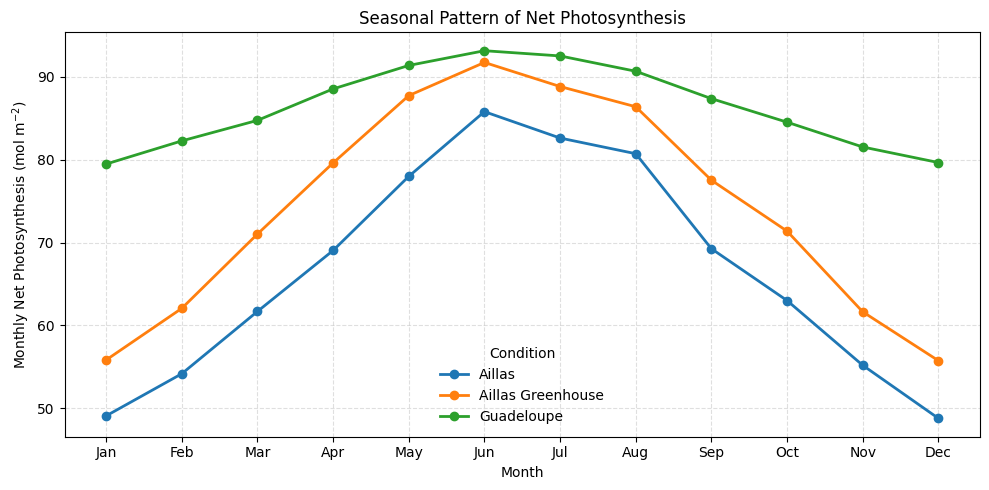

In [103]:
import calendar

# ── 1. Aggregate by month number (1–12) and keep numeric index ─────────────
monthly_tot = (
    df_daily
    .groupby(df_daily.index.month)[["A_n_Aillas",
                                    "A_n_Gh_Aillas",
                                    "A_n_Guadeloupe"]]
    .sum()
    .reindex(range(1, 13))    # make sure Jan (=1) comes first
)

# ── 2. Plot ────────────────────────────────────────────────────────────────
label_map = {
    "A_n_Aillas":        "Aillas",
    "A_n_Gh_Aillas":     "Aillas Greenhouse",
    "A_n_Guadeloupe":    "Guadeloupe"
}

fig, ax = plt.subplots(figsize=(10, 5))
for col in monthly_tot.columns:
    ax.plot(monthly_tot.index,
            monthly_tot[col],
            marker="o", lw=2, label=label_map[col])

# custom month names on x-axis
ax.set_xticks(range(1, 13))
ax.set_xticklabels(list(calendar.month_abbr)[1:])   # ['Jan', 'Feb', … 'Dec']

ax.set_xlabel("Month")
ax.set_ylabel("Monthly Net Photosynthesis (mol m$^{-2}$)")
ax.set_title("Seasonal Pattern of Net Photosynthesis")
ax.grid(ls="--", alpha=0.4)
ax.legend(title="Condition", frameon=False)
plt.tight_layout()


In [104]:
# 1. Yearly TOTAL net photosynthesis (mol m⁻² year⁻¹)
yearly_psn = (
    df_daily[["A_n_Aillas", "A_n_Gh_Aillas", "A_n_Guadeloupe"]]
    .resample("YE")
    .sum()
)
yearly_psn.index = yearly_psn.index.year     # nice year labels

# 2. Yearly mean temperatures & mean PPFD (already computed daily)
yearly_env = (
    df_daily
    .resample("Y")
    .agg(
        Avg_T_Amb_Aillas         = ("T_Amb_Aillas",       "mean"),
        Avg_T_Gh_Aillas          = ("T_Gh_Aillas",        "mean"),
        Avg_T_Amb_Guadeloupe     = ("T_Amb_Guadeloupe",   "mean"),
        Avg_PPFD_Aillas          = ("PPFD_Aillas",        "mean"),
        Avg_PPFD_Aillas_Gh       = ("PPFD_Aillas_Gh",     "mean"),
        Avg_PPFD_Guadeloupe      = ("PPFD_Guadeloupe",    "mean")
    )
)
yearly_env.index = yearly_env.index.year

# 3. Merge and show
yearly_summary = yearly_psn.join(yearly_env)

print(yearly_summary.to_markdown(floatfmt=".1f"))


|   date |   A_n_Aillas |   A_n_Gh_Aillas |   A_n_Guadeloupe |   Avg_T_Amb_Aillas |   Avg_T_Gh_Aillas |   Avg_T_Amb_Guadeloupe |   Avg_PPFD_Aillas |   Avg_PPFD_Aillas_Gh |   Avg_PPFD_Guadeloupe |
|-------:|-------------:|----------------:|-----------------:|-------------------:|------------------:|-----------------------:|------------------:|---------------------:|----------------------:|
|   1990 |        797.3 |           889.5 |           1035.8 |               13.5 |              16.1 |                   25.9 |           57525.8 |              43144.3 |               85135.6 |


<ipython-input-104-370002498>:12: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("Y")


In [105]:
# ────────────────────────────────────────────────────────────────────────────
# 1.  Define unit labels
# ────────────────────────────────────────────────────────────────────────────
unit_labels = {
    # Net photosynthesis totals  (mol m-2 yr-1)
    "A_n_Aillas"        : "A_n_Aillas (mol m⁻² yr⁻¹)",
    "A_n_Gh_Aillas"     : "A_n_Aillas Gh (mol m⁻² yr⁻¹)",
    "A_n_Guadeloupe"    : "A_n_Guadeloupe (mol m⁻² yr⁻¹)",

    # Mean temperatures  (°C)
    "Avg_T_Amb_Aillas"      : "Avg T Aillas (°C)",
    "Avg_T_Gh_Aillas"       : "Avg T Aillas Gh (°C)",
    "Avg_T_Amb_Guadeloupe"  : "Avg T Guadeloupe (°C)",

    # Mean PPFD  (µmol m-2 s-1)
    "Avg_PPFD_Aillas"          : "Avg PPFD Aillas (µmol m⁻² s⁻¹)",
    "Avg_PPFD_Aillas_Gh"       : "Avg PPFD Aillas Gh (µmol m⁻² s⁻¹)",
    "Avg_PPFD_Guadeloupe"      : "Avg PPFD Guadeloupe (µmol m⁻² s⁻¹)"
}

# ────────────────────────────────────────────────────────────────────────────
# 2.  Apply the new labels
# ────────────────────────────────────────────────────────────────────────────
yearly_summary_units = yearly_summary.rename(columns=unit_labels)

# ────────────────────────────────────────────────────────────────────────────
# 3.  Display the table in Markdown (one decimal place for all values)
# ────────────────────────────────────────────────────────────────────────────
print(yearly_summary_units.to_markdown(floatfmt=".1f"))


|   date |   A_n_Aillas (mol m⁻² yr⁻¹) |   A_n_Aillas Gh (mol m⁻² yr⁻¹) |   A_n_Guadeloupe (mol m⁻² yr⁻¹) |   Avg T Aillas (°C) |   Avg T Aillas Gh (°C) |   Avg T Guadeloupe (°C) |   Avg PPFD Aillas (µmol m⁻² s⁻¹) |   Avg PPFD Aillas Gh (µmol m⁻² s⁻¹) |   Avg PPFD Guadeloupe (µmol m⁻² s⁻¹) |
|-------:|----------------------------:|-------------------------------:|--------------------------------:|--------------------:|-----------------------:|------------------------:|---------------------------------:|------------------------------------:|-------------------------------------:|
|   1990 |                       797.3 |                          889.5 |                          1035.8 |                13.5 |                   16.1 |                    25.9 |                          57525.8 |                             43144.3 |                              85135.6 |


Change to PPFD/ seconds

In [106]:
# ── 1. Pick the year you want to display  ───────────────────────────────────
yr = 1990                                   # <<< change if you have multiple years
row = yearly_summary.loc[yr]                # Series with all metrics for that year

# ── 2. Build a “condition × metric” table  ──────────────────────────────────
summary_by_condition = pd.DataFrame(
    {
        "Net Photosynthesis (mol m⁻² yr⁻¹)": [
            row["A_n_Aillas"],
            row["A_n_Gh_Aillas"],
            row["A_n_Guadeloupe"]
        ],
        "Average Temperature (°C)": [
            row["Avg_T_Amb_Aillas"],
            row["Avg_T_Gh_Aillas"],
            row["Avg_T_Amb_Guadeloupe"]
        ],
          "Average PPFD (µmol m⁻² s⁻¹)": [          # ← new column, no conversion
            row["Avg_PPFD_Aillas"],
            row["Avg_PPFD_Aillas_Gh"],
            row["Avg_PPFD_Guadeloupe"]
        ]
    },
    index=["Aillas", "Aillas GH", "Guadeloupe"]
)

# ── 3. Display in Markdown ─────────────────────────────────────────────────
print(summary_by_condition.to_markdown(floatfmt=".1f"))


|            |   Net Photosynthesis (mol m⁻² yr⁻¹) |   Average Temperature (°C) |   Average PPFD (µmol m⁻² s⁻¹) |
|:-----------|------------------------------------:|---------------------------:|------------------------------:|
| Aillas     |                               797.3 |                       13.5 |                       57525.8 |
| Aillas GH  |                               889.5 |                       16.1 |                       43144.3 |
| Guadeloupe |                              1035.8 |                       25.9 |                       85135.6 |


|       Yearly (1990)     |   Net Photosynthesis (mol m⁻² yr⁻¹) |   Average Temperature (°C) |   Average PPFD (mol m⁻² yr⁻¹) |
|:-----------|------------------------------------:|---------------------------:|------------------------------:|
| Aillas     |                               797.3 |                       13.5 |                       57525.8 |
| Aillas GH  |                               889.5 |                       16.1 |                       43144.3 |
| Guadeloupe |                              1035.8 |                       25.9 |                       85135.6 |

#Export to CSV

In [107]:
data.to_csv("/content/data.csv", index=False)
df_daily.to_csv("/content/df_daily.csv", index=False)

# Download in Colab
from google.colab import files
files.download("/content/data.csv")
files.download("/content/df_daily.csv")
out_path = "/content/monthly_net_photosynthesis.csv"

files.download(out_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>